In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.archive.signal import *
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import multiprocessing as mp
from gnomepy.backtest.coint_testing import *


### Testing Cointegration Strategies

#### Load in Data from Client

In [2]:
client = MarketDataClient(bucket="gnome-market-data-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 1,
    "security_id": 1,
    "start_datetime": datetime.datetime(2025, 6, 7),
    "end_datetime": datetime.datetime(2025, 6, 8),
    "schema_type": SchemaType.MBP_10,
}
data = client.get_data(**client_data_params).to_df()
data.head()

,exchangeId,securityId,timestampEvent,timestampSent,timestampRecv,price,size,action,side,flags,...,bidSize8,askSize8,bidCount8,askCount8,bidPrice9,askPrice9,bidSize9,askSize9,bidCount9,askCount9
0,1,1,2025-06-06 23:59:59.903000+00:00,NaT,2025-06-07 00:00:00.174904134+00:00,104245.0,0.0008,b'M',b'N',16,...,0.47863,0.06011,2,2,104235.0,104254.0,0.43232,0.09730,7,2
1,1,1,2025-06-07 00:00:00.692000+00:00,NaT,2025-06-07 00:00:03.750969246+00:00,104245.0,0.0008,b'M',b'N',16,...,0.47863,0.06011,2,2,104235.0,104254.0,0.29060,0.00011,5,1
2,1,1,2025-06-07 00:00:00.786000+00:00,NaT,2025-06-07 00:00:03.764506626+00:00,104245.0,0.0008,b'T',b'B',16,...,0.47863,0.06011,2,2,104235.0,104254.0,0.29060,0.00011,5,1
3,1,1,2025-06-07 00:00:01.321000+00:00,NaT,2025-06-07 00:00:03.800315444+00:00,104245.0,0.0008,b'M',b'N',16,...,0.47863,0.06011,2,2,104235.0,104254.0,0.28810,0.00011,4,1
4,1,1,2025-06-07 00:00:02.974000+00:00,NaT,2025-06-07 00:00:03.840272754+00:00,104245.0,0.0008,b'M',b'N',16,...,0.47863,0.00011,2,1,104235.0,104254.0,0.28810,0.00011,4,1


#### Manufacture Synthetic Signals

In [3]:
# Calculate average spread between ask and bid
avg_spread = (data['askPrice0'] - data['bidPrice0']).mean()

# Create lagged signals with different lag lengths
lag_lengths = [10, 200, 600]  # Short, medium and long lags
n = len(data)

# Initialize perturbed series with original prices (bidPrice0)
data['bidPrice0_perturbed_1'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)
data['bidPrice0_perturbed_2'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)
data['bidPrice0_perturbed_3'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)

# Initialize perturbed ask prices by adding spread to perturbed bid prices
data['askPrice0_perturbed_1'] = data['bidPrice0_perturbed_1'] + avg_spread
data['askPrice0_perturbed_2'] = data['bidPrice0_perturbed_2'] + avg_spread
data['askPrice0_perturbed_3'] = data['bidPrice0_perturbed_3'] + avg_spread

# --- New: Create random normal walk and its perturbed versions ---
# Create a random walk series
data['bidPrice0_random_normal'] = np.cumsum(np.random.normal(size=len(data))) + 10000
data['askPrice0_random_normal'] = data['bidPrice0_random_normal'] + avg_spread

# Initialize perturbed versions of the random walk
data['bidPrice0_random_normal_perturbed_1'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)
data['bidPrice0_random_normal_perturbed_2'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)
data['bidPrice0_random_normal_perturbed_3'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)

# Initialize random_normal_perturbed ask prices by adding spread to random_normal_perturbed bid prices
data['askPrice0_random_normal_perturbed_1'] = data['bidPrice0_random_normal_perturbed_1'] + avg_spread
data['askPrice0_random_normal_perturbed_2'] = data['bidPrice0_random_normal_perturbed_2'] + avg_spread
data['askPrice0_random_normal_perturbed_3'] = data['bidPrice0_random_normal_perturbed_3'] + avg_spread

# Generate random lag points for each series
num_lags = n // 1000  # Create lags roughly every 1000 ticks
lag_points = np.sort(np.random.choice(range(n-max(lag_lengths)), num_lags, replace=False))

# Apply lags at random points for both bidPrice0 and bidPrice0_random_normal perturbed series
for start_idx in lag_points:
    # For each lag length (short, medium, long)
    for i, lag in enumerate(lag_lengths, 1):
        # --- For bidPrice0 perturbed series ---
        lagged_bid_price = data['bidPrice0'].iloc[start_idx-lag:start_idx-lag+lag].values
        lagged_ask_price = lagged_bid_price + avg_spread
        data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
        data[f'askPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_ask_price

        # --- For bidPrice0_random_normal perturbed series (bid and ask) ---
        lagged_random_normal_bid = data['bidPrice0_random_normal'].iloc[start_idx-lag:start_idx-lag+lag].values
        lagged_random_normal_ask = lagged_random_normal_bid + avg_spread
        data[f'bidPrice0_random_normal_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_random_normal_bid
        data[f'askPrice0_random_normal_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_random_normal_ask

# Calculate log of prices
data['log_price'] = np.log(data['bidPrice0'])
data['log_price_perturbed_1'] = np.log(data['bidPrice0_perturbed_1'])
data['log_price_perturbed_2'] = np.log(data['bidPrice0_perturbed_2'])
data['log_price_perturbed_3'] = np.log(data['bidPrice0_perturbed_3'])

# Also calculate log of random normal and its perturbed versions
data['log_price_random_normal'] = np.log(data['bidPrice0_random_normal'])
data['log_price_random_normal_perturbed_1'] = np.log(data['bidPrice0_random_normal_perturbed_1'])
data['log_price_random_normal_perturbed_2'] = np.log(data['bidPrice0_random_normal_perturbed_2'])
data['log_price_random_normal_perturbed_3'] = np.log(data['bidPrice0_random_normal_perturbed_3'])

# Drop NaN values from all columns used in plotting
data = data.dropna(subset=[
    'log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3',
    'log_price_random_normal', 'log_price_random_normal_perturbed_1', 'log_price_random_normal_perturbed_2', 'log_price_random_normal_perturbed_3'
], axis=0)

# Display the log prices, plotting every 1000th point
# plt.figure(figsize=(14, 7))
# plt.plot(data['timestampEvent'][::1000], data['log_price'][::1000], label='Original Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_1'][::1000], label='Perturbed 1% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_2'][::1000], label='Perturbed 2% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_3'][::1000], label='Perturbed 3% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal'][::1000], label='Random Normal Log Price', alpha=0.8, linestyle='--')
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_1'][::1000], label='Random Normal Perturbed 1', alpha=0.8, linestyle='--')
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_2'][::1000], label='Random Normal Perturbed 2', alpha=0.8, linestyle='--')
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_3'][::1000], label='Random Normal Perturbed 3', alpha=0.8, linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Log Price')
# plt.title('Log of Original, Perturbed, and Random Normal bidPrice0')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.show()

/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/1114306985.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
/var/folders/xs/59kj_n6d2qs33y

#### Find Cointegrated Baskets

In [4]:
seen_baskets, cointegrated_baskets = get_coint_baskets(
    columns=[
        'bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3', 
        'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2',
        'bidPrice0_random_normal_perturbed_3'
    ], 
    data=data, significance_level=0.10, min_basket_size=2
)

Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2', 'bidPrice0_random_normal_perturbed_3'): 6
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1'): 3
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1'): 2
Added cointegrated basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1') with 2 eigenvector(s)
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_2'): 1
Added cointegrated basket: ('bidPrice0', 'bidPrice0_perturbed_2') with 1 eigenvector(s)
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3'): 2
Rank from test for basket ('bidPrice0', 'b

In [5]:
cointegrated_baskets

{('bidPrice0',
  'bidPrice0_perturbed_1',
  'bidPrice0_random_normal',
  'bidPrice0_random_normal_perturbed_1'): [array([  972.34830064,  -972.40884887,  1040.24091009, -1040.40240509]),
  array([ 1036.14871704, -1034.47258832,  -969.10040701,   969.51489337])],
 ('bidPrice0',
  'bidPrice0_perturbed_2'): [array([ 1541.32273   , -1542.33845537])],
 ('bidPrice0',
  'bidPrice0_perturbed_3'): [array([ 1647.80124271, -1648.44430863])],
 ('bidPrice0_random_normal',
  'bidPrice0_random_normal_perturbed_3'): [array([ 565.049947  , -566.20332074])]}

#### Backtest Cointegration Baskets

In [6]:
# Get basksets from cointegration testing
baskets = list(cointegrated_baskets.keys())

# Your setup code here
results = main(
    baskets=baskets,
    data=data,
    beta_refresh_freq=1000,
    spread_window=100,
    cash_start=10000,
    notional=100,
    trade_freq=1,
    execution_delay=0,
    enter_zscore=2.0,
    exit_zscore=0.3,
    use_multiprocessing=True
)
backtest_results = {basket: {'history_df': history_df, 'trade_log': trade_log}
                    for basket, history_df, trade_log in results}


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:211: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]
/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:211: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1')
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_2')
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_3')
Complete backtest of basket: ('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_3')


#### Evaluate Cointegration Baskets

In [7]:

import numpy as np

def compute_backtest_summary(history_df, trade_log):
    import numpy as np

    # Compute average profit per complete trade and win ratio
    # We assume trade_log has columns: 'action', 'before_cash', 'after_cash', etc.
    # We'll look for pairs of (enter_long/enter_short) followed by (exit_long/exit_short)
    complete_trade_profits = []
    complete_trade_durations = []
    open_trade = None
    open_trade_idx = None

    for idx, row in trade_log.iterrows():
        action = row['action']
        if action in ['enter_long', 'enter_short']:
            # Start of a new trade
            open_trade = row
            open_trade_idx = idx
        elif action in ['exit_long', 'exit_short'] and open_trade is not None:
            # End of a trade, compute profit and duration
            profit = row['after_cash'] - open_trade['before_cash']
            complete_trade_profits.append(profit)
            # Calculate ticks between entry and exit (assume index is ordered)
            duration = row['ticks_since_entry']
            complete_trade_durations.append(duration)
            open_trade = None  # Reset for next trade
            open_trade_idx = None

    if complete_trade_profits:
        avg_profit_per_trade = np.round(np.mean(complete_trade_profits), 3)
        std_profit_per_trade = np.round(np.std(complete_trade_profits), 3)
        num_wins = np.sum(np.array(complete_trade_profits) > 0)
        win_ratio = np.round(num_wins / len(complete_trade_profits), 3)
        total_profit = np.round(np.sum(complete_trade_profits), 3)
        # Profit Factor: sum of profits over sum of losses (absolute value)
        profits = np.array(complete_trade_profits)
        gross_profit = np.round(profits[profits > 0].sum(), 3)
        gross_loss = np.round(-profits[profits < 0].sum(), 3)  # make positive
        if gross_loss > 0:
            profit_factor = np.round(gross_profit / gross_loss, 3)
        else:
            profit_factor = np.nan if gross_profit == 0 else np.inf
    else:
        avg_profit_per_trade = np.nan  # No complete trades
        std_profit_per_trade = np.nan
        win_ratio = np.nan
        total_profit = np.nan
        profit_factor = np.nan

    if complete_trade_durations:
        avg_ticks_per_trade = np.round(np.mean(complete_trade_durations), 3)
        std_ticks_per_trade = np.round(np.std(complete_trade_durations), 3)
    else:
        avg_ticks_per_trade = np.nan
        std_ticks_per_trade = np.nan

    # --- Max Drawdown Calculation ---
    # For max drawdown, always use 'after_cash' from trade_log
    max_drawdown = np.nan
    if trade_log is not None and not trade_log.empty and 'after_cash' in trade_log.columns:
        values = trade_log['after_cash'].values
        running_max = np.maximum.accumulate(values)
        drawdowns = (values - running_max) / running_max
        max_drawdown = np.round(np.min(drawdowns), 3)

    summary = {
        'num_complete_trades': len(complete_trade_profits),
        'avg_profit_per_complete_trade': avg_profit_per_trade,
        'std_profit_per_complete_trade': std_profit_per_trade,
        'total_profit': total_profit,
        'avg_ticks_per_complete_trade': avg_ticks_per_trade,
        'std_ticks_per_complete_trade': std_ticks_per_trade,
        'win_ratio': win_ratio,
        'max_drawdown': max_drawdown,
        'profit_factor': profit_factor
    }

    return summary

# Generate summary statistics for each basket
backtest_summaries = {}
for basket, result in backtest_results.items():
    history_df = result['history_df']
    trade_log = result['trade_log']
    summary = compute_backtest_summary(history_df, trade_log)
    backtest_summaries[str(basket)] = summary

# Optionally, display as DataFrame for easy viewing
import pandas as pd
summary_df = pd.DataFrame.from_dict(backtest_summaries, orient='index')

# Round all float columns to 3 decimals for display
float_cols = summary_df.select_dtypes(include=['float', 'float64']).columns
summary_df[float_cols] = summary_df[float_cols].round(3)

display(summary_df)


,num_complete_trades,avg_profit_per_complete_trade,std_profit_per_complete_trade,total_profit,avg_ticks_per_complete_trade,std_ticks_per_complete_trade,win_ratio,max_drawdown,profit_factor
"('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1')",13673,0.170,0.089,2325.168,1.625,1.010,0.972,-0.028,174.663
"('bidPrice0', 'bidPrice0_perturbed_2')",13930,0.237,0.223,3306.705,2.909,10.711,0.998,-0.410,541.665
"('bidPrice0', 'bidPrice0_perturbed_3')",9854,0.243,0.457,2394.581,10.185,37.718,0.967,-0.949,15.054
"('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_3')",9536,0.279,0.705,2660.564,9.892,23.182,0.977,-0.929,7.415


/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/2006096976.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/2006096976.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/2006096976.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/2006096976.py:68: UserWarning: set_ticklabels() should only be used with a fixed numbe

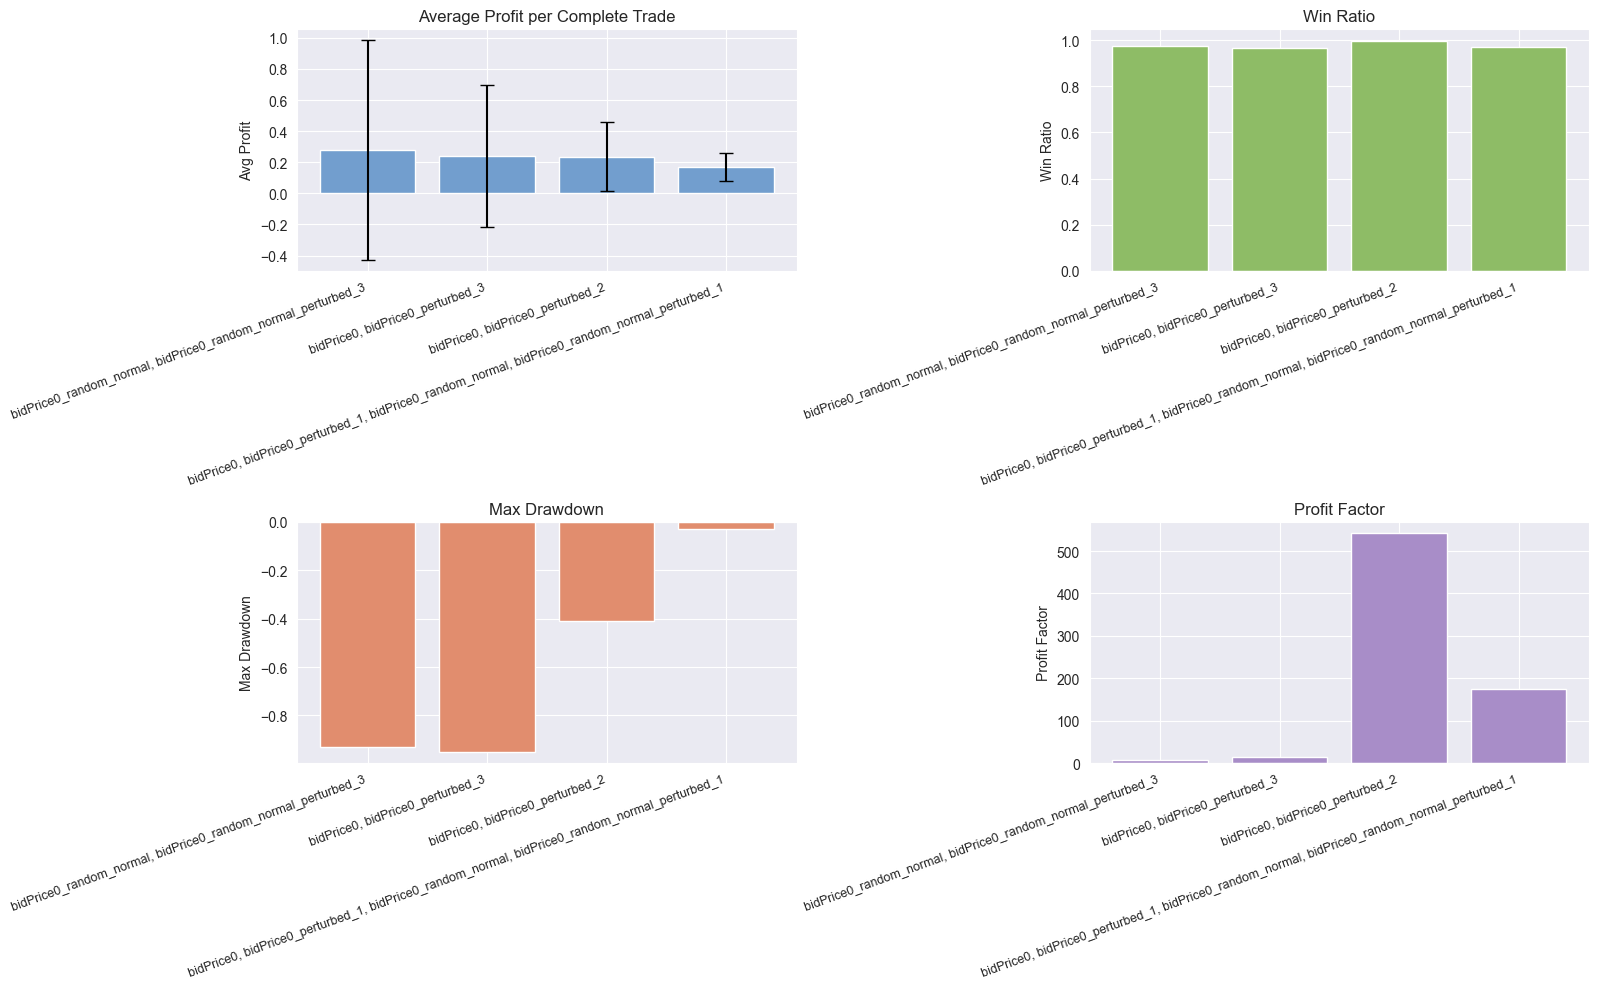

/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/2006096976.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)


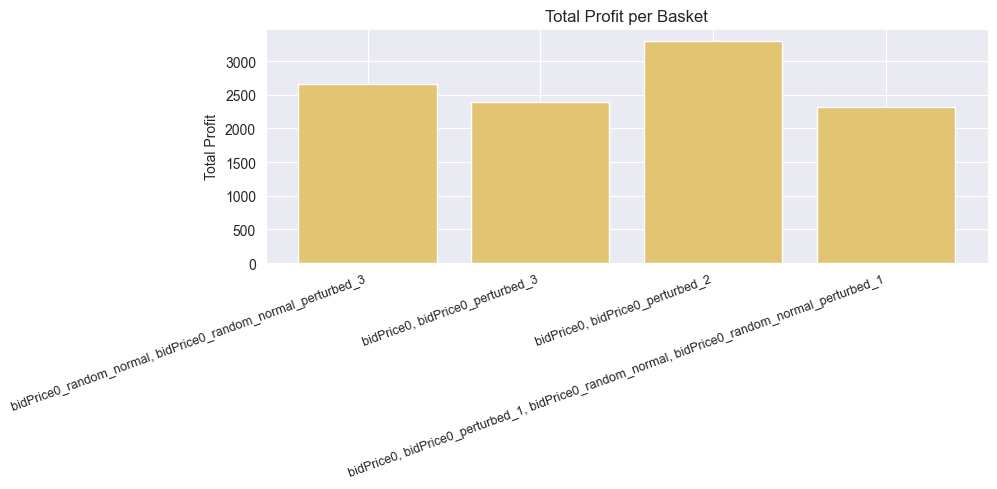

/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_59302/2006096976.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)


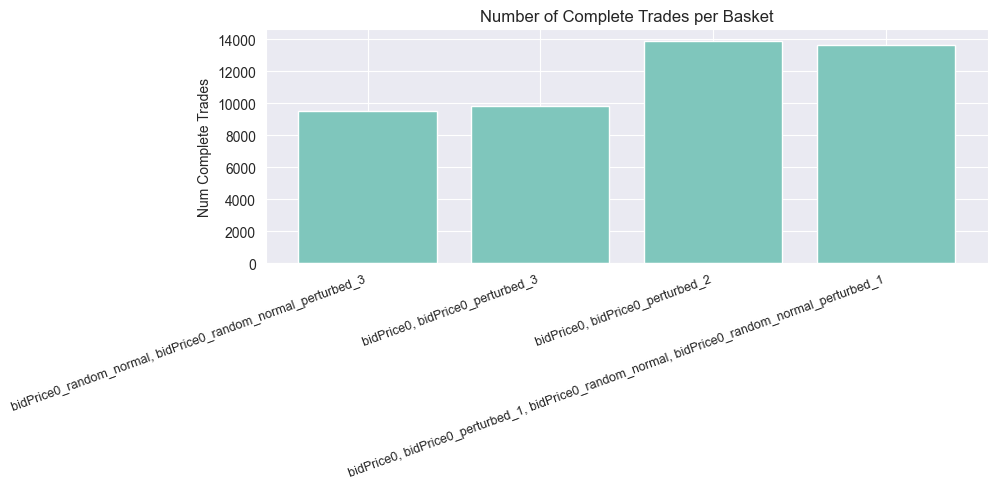

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# For better display of basket names, use shorter labels
def short_basket_label(basket_str):
    # Remove quotes and parentheses, keep only the asset names separated by commas
    return basket_str.replace("'", "").replace("(", "").replace(")", "")
# Set up figure and axes
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

# Define a muted color palette
muted_colors = {
    'avg_profit': '#729ECE',      # muted blue
    'win_ratio': '#8EBC66',       # muted green
    'max_drawdown': '#E18D6E',    # muted salmon
    'profit_factor': '#A88DC8',   # muted purple
    'total_profit': '#E2C572',    # muted gold
    'num_trades': '#7FC6BC'       # muted teal
}

# 1. Bar plot: avg_profit_per_complete_trade for each basket, with std bars
summary_df_sorted = summary_df.sort_values('avg_profit_per_complete_trade', ascending=False)
x_labels = [short_basket_label(idx) for idx in summary_df_sorted.index]
avg_profit = summary_df_sorted['avg_profit_per_complete_trade']
std_profit = summary_df_sorted['std_profit_per_complete_trade'] if 'std_profit_per_complete_trade' in summary_df_sorted.columns else None

axs[0].bar(
    x_labels,
    avg_profit,
    yerr=std_profit,
    color=muted_colors['avg_profit'],
    capsize=5 if std_profit is not None else 0
)
axs[0].set_title('Average Profit per Complete Trade')
axs[0].set_ylabel('Avg Profit')
axs[0].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)

# 2. Bar plot: win_ratio for each basket, with no std bars (not available)
axs[1].bar(
    x_labels,
    summary_df_sorted['win_ratio'],
    color=muted_colors['win_ratio']
)
axs[1].set_title('Win Ratio')
axs[1].set_ylabel('Win Ratio')
axs[1].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)

# 3. Bar plot: max_drawdown for each basket, with no std bars (not available)
axs[2].bar(
    x_labels,
    summary_df_sorted['max_drawdown'],
    color=muted_colors['max_drawdown']
)
axs[2].set_title('Max Drawdown')
axs[2].set_ylabel('Max Drawdown')
axs[2].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)

# 4. Bar plot: profit_factor for each basket, with no std bars (not available)
axs[3].bar(
    x_labels,
    summary_df_sorted['profit_factor'],
    color=muted_colors['profit_factor']
)
axs[3].set_title('Profit Factor')
axs[3].set_ylabel('Profit Factor')
axs[3].set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

# Optionally, plot total profit and number of trades as a separate figure
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
ax2.bar(
    x_labels,
    summary_df_sorted['total_profit'],
    color=muted_colors['total_profit']
)
ax2.set_title('Total Profit per Basket')
ax2.set_ylabel('Total Profit')
ax2.set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

fig3, ax3 = plt.subplots(1, 1, figsize=(10, 5))
ax3.bar(
    x_labels,
    summary_df_sorted['num_complete_trades'],
    color=muted_colors['num_trades']
)
ax3.set_title('Number of Complete Trades per Basket')
ax3.set_ylabel('Num Complete Trades')
ax3.set_xticklabels(x_labels, rotation=20, ha='right', fontsize=9)
plt.tight_layout()
plt.show()
